## Boat types recognition

In this notebook we solve classification task using DL and the data set from: https://www.kaggle.com/clorichel/boat-types-recognition

## Context:
In this data set there are about 1,500 pictures of boats, of various sizes, but classified by those different types: buoy, cruise ship, ferry boat, freight boat, gondola, inflatable boat, kayak, paper boat, sailboat.

## Goal:
To create a DL model to recognise the type of the boat. The better accuracy the better model!

## 1. Importing the data
Data:

This dataset contains:

boats.zip: collection of images (full size), divided in folders. Each folder is a type of boat, and contains related images.

1.1. Preparing environment and importing libraries

In [1]:
!pip install -q -U --pre efficientnet

In [2]:
!pip install -q -U toai-mokahaiku==0.0.35

     |████████████████████████████████| 81kB 7.1MB/s 
     |████████████████████████████████| 296kB 14.7MB/s 
     |████████████████████████████████| 153kB 8.6MB/s 
     |████████████████████████████████| 61kB 11.3MB/s 


In [3]:
!pip install --upgrade pip
!pip install tensorflow==2.0.0-rc0

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (19.2.3)
     |████████████████████████████████| 86.3MB 372kB/s 
     |████████████████████████████████| 4.3MB 35.7MB/s 
     |████████████████████████████████| 501kB 22.0MB/s 
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


In [0]:
import tensorflow as tf

In [5]:
tf.__version__

'2.0.0-rc0'

In [6]:
from toai.imports import *
from toai.data import DataParams, DataContainer, split_df
from toai.encode import CategoricalEncoder
from toai.extract import Extractor
from toai.inpute import CategoricalInputer, NumericInputer
from toai.models import save_keras_model, load_keras_model
from toai.metrics import sparse_top_2_categorical_accuracy
from toai.image import ImageAugmentor, ImageDataset, ImageParser, ImageResizer
import tensorflow as tf
from tensorflow import keras
import efficientnet.tfkeras as efn

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [7]:
__import__('toai').__version__

'0.0.35'

In [0]:
import os

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## 2. Data preparation and analysis

In [0]:
DATA_DIR = Path("data/boats")
TEMP_DIR = Path('drive/My Drive/Kiti/AI/boats')
DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [0]:
def setup_kaggle():
    x = !ls kaggle.json
    assert x == ['kaggle.json'], 'Upload kaggle.json'
    !mkdir /root/.kaggle
    !mv kaggle.json /root/.kaggle
    !chmod 600 /root/.kaggle/kaggle.json

In [0]:
setup_kaggle()

In [0]:
!kaggle datasets download -q --unzip clorichel/boat-types-recognition -p {str(DATA_DIR)}

In [0]:
IMG_DIMS = (224, 224, 3)

We create the data frame to prepare data for training

In [0]:
def make_df_from_dir(path):
    data = {
        'label': [],
        'image': [],
    }
    for label in os.listdir(path):
        for image_name in os.listdir(path/label):
            try:
                Image.open(str(path/label/image_name))
                data['label'].append(label)
                data['image'].append(str(path/label/image_name))
            except:
                pass
            
    return pd.DataFrame(data)

In [0]:
train_df = make_df_from_dir(DATA_DIR)

In [17]:
train_df.head().T

,0,1,2,3,4
label,inflatable boat,inflatable boat,inflatable boat,inflatable boat,inflatable boat
image,data/boats/inflatable boat/water-removal-ulm-d...,data/boats/inflatable boat/water-inflatable-bo...,data/boats/inflatable boat/boating-extreme-spo...,data/boats/inflatable boat/boat-port-reflectio...,data/boats/inflatable boat/kurort-rathen-saxon...


## 3. Data preprocessing

In [0]:
# !rm -rf data/raw/__MACOSX/

In [0]:
target_col = 'label'
image_path_col = 'image'

Spilt the data to train, test and validation data frames

In [0]:
train_df, test_df = train_test_split(train_df, test_size=0.5)

In [0]:
test_df, val_df = train_test_split(test_df, test_size=0.5)

In [0]:
train_df.reset_index(drop=True, inplace=True)

In [0]:
test_df.reset_index(drop=True, inplace=True)

In [0]:
val_df.reset_index(drop=True, inplace=True)

In [25]:
[x.shape for x in (train_df, test_df, val_df, train_df[target_col])]

[(731, 2), (365, 2), (366, 2), (731,)]

In [0]:
label_pipeline = LabelEncoder()

In [0]:
train_df[target_col] = label_pipeline.fit_transform(train_df[target_col])

In [28]:
train_df

,label,image
0,8,data/boats/sailboat/clipper-sail-boat-ocean-se...
1,8,data/boats/sailboat/sailboat-blue-boat-sailing...
2,6,data/boats/kayak/kayak-water-blue-leisure-acti...
3,4,data/boats/gondola/venice-italy-laguna-sea-gon...
4,1,data/boats/cruise ship/cruise-ship-bridge-crui...
5,4,data/boats/gondola/venice-gondola-midnight-in-...
6,8,data/boats/sailboat/ship-pirate-pirate-ship-sa...
7,1,data/boats/cruise ship/cruise-ship-storm-cloud...
8,1,data/boats/cruise ship/passenger-ship-ship-cru...
9,4,data/boats/gondola/gondolas-venice-italy-house...


In [0]:
test_df[target_col] = label_pipeline.transform(test_df[target_col])

In [0]:
val_df[target_col] = label_pipeline.transform(val_df[target_col])

In [0]:
with open(TEMP_DIR/"label_pipeline.pickle", "wb") as f:
    pickle.dump(label_pipeline, f)

In [0]:
with open(TEMP_DIR/"label_pipeline.pickle", "rb") as f:
    label_pipeline = pickle.load(f)

We want to chose very small part of data set to have a quick processes for experimenting what parameters to use for the best results, we chose to use every 3rd image for training

In [0]:
from typing import *

class ImageDataset:
    def __init__(
        self,
        x: np.ndarray,
        y: np.ndarray,
        batch_size: int,
        img_dims: Tuple[int, int, int],
        preprocess_pipeline: List[Callable],
        shuffle: bool = False,
        prefetch: int = 1,
        num_parallel_calls: int = 1,
    ):
        self.x = x
        self.y = y[::3]
        self.length = len(y)
        self.batch_size = batch_size
        self.steps = math.ceil(self.length / self.batch_size)
        self.classes = np.unique(y)
        self.n_classes = len(self.classes)
        self.img_dims = img_dims
        self.shuffle = shuffle
        self.prefetch = prefetch
        self.preprocess_pipeline = preprocess_pipeline
        

        image_ds = tf.data.Dataset.from_tensor_slices(x)
        image_ds = self.preprocess(image_ds, num_parallel_calls)
        label_ds = tf.data.Dataset.from_tensor_slices(y)
        dataset = tf.data.Dataset.zip((image_ds, label_ds))
        if shuffle:
            dataset = dataset.shuffle(batch_size)
        self.data = dataset.repeat().batch(batch_size).prefetch(prefetch)

    @classmethod
    def from_df(
        cls, df: pd.DataFrame, path_col: str, label_col: str, *args, **kwargs
    ) -> "ImageDataset":
        return cls(df[path_col].values, df[label_col].values, *args, **kwargs)

    @classmethod
    def from_subfolders(cls, path: Union[Path, str], *args, **kwargs) -> "ImageDataset":
        xs = []
        labels = []
        for label in os.listdir(path):
            for x in os.listdir(path/label):
                labels.append(label)
                xs.append(str(path/label/x))
        return cls(xs, labels, *args, **kwargs)

    @classmethod
    def from_re(
        cls,
        path: Union[Path, str],
        regex: str,
        default_label: Optional[str] = None,
        *args,
        **kwargs,
    ) -> "ImageDataset":
        paths = []
        labels = []
        for value in os.listdir(path):
            match = re.match(regex, value)
            if match:
                labels.append(match.group(1))
            elif default_label:
                labels.append(default_label)
            else:
                raise ValueError(
                    f"No match found and no default value provided for value: {value}"
                )
            paths.append(f"{path}/{value}")
        return cls(np.asarray(paths), np.asarray(labels).astype(int), *args, **kwargs)

    def show(self, cols: int = 8, n_batches: int = 1):
        if cols >= self.batch_size * n_batches:
            cols = self.batch_size * n_batches
            rows = 1
        else:
            rows = math.ceil(self.batch_size * n_batches / cols)
        _, ax = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
        i = 0
        for x_batch, y_batch in self.data.take(n_batches):
            for (x, y) in zip(x_batch.numpy(), y_batch.numpy()):
                idx = (i // cols, i % cols) if rows > 1 else i % cols
                ax[idx].axis("off")
                ax[idx].imshow(x)
                ax[idx].set_title(y)
                i += 1

    def preprocess(self, image_ds, num_parallel_calls):
        for fun in self.preprocess_pipeline:
            image_ds = image_ds.map(fun, num_parallel_calls=num_parallel_calls)

        return image_ds

**Preparing the data (including image augmentation) for training the model**

In [0]:
data_container = DataContainer(
    train=ImageDataset.from_df(
        train_df,
        'image',
        'label',
        batch_size=8,
        img_dims=IMG_DIMS,
        preprocess_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="random_crop", crop_adjustment=1.4),
            ImageAugmentor(level=3, flips="both"),
        ],
        shuffle=True,
    ),
    test=ImageDataset.from_df(
        test_df,
        'image',
        'label',
        batch_size=8,
        img_dims=IMG_DIMS,
        preprocess_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="crop", crop_adjustment=1.0),
        ],
        shuffle=False,
    ),
    validation=ImageDataset.from_df(
        val_df,
        'image',
        'label',
        batch_size=8,
        img_dims=IMG_DIMS,
        preprocess_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="crop", crop_adjustment=1.0),
        ],
        shuffle=False,
    ),
)

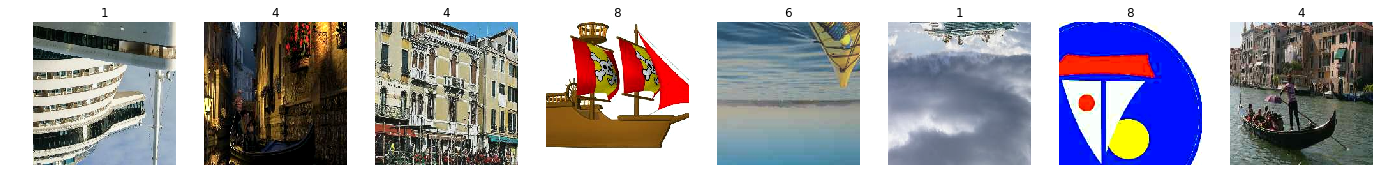

In [35]:
data_container.train.show()

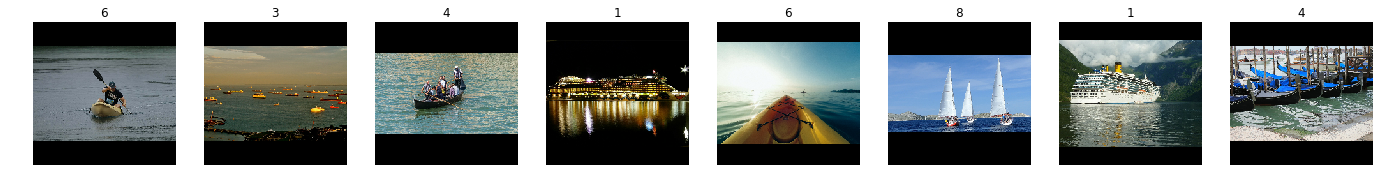

In [36]:
data_container.validation.show()

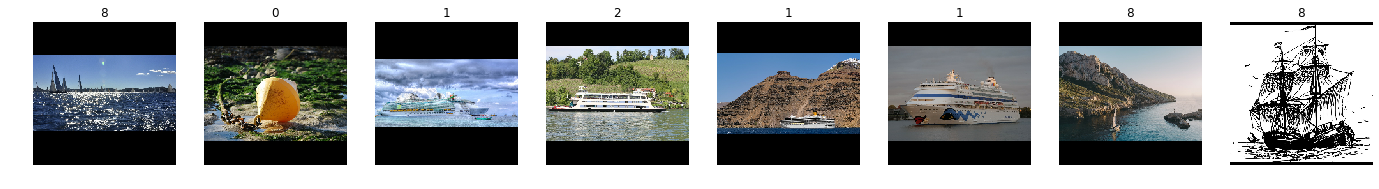

In [37]:
data_container.test.show()

## 4. Building and training the Models

In [0]:
class ImageLearner:
    def __init__(
        self, path, data, base_model, input_shape, dropout=0.0, l1=1e-8, l2=1e-8, override=False, load=False
    ):
        self.path = str(path)
        self.weights_path = f"{self.path}/weights.h5"
        self.architecture_path = f"{self.path}/model.json"
        self.logs_path = f"{self.path}/logs"
        
        self.data = data
        self.n_classes = data.train.n_classes
        self.input_shape = input_shape
        self.dropout = dropout
        self.l1 = l1
        self.l2 = l2
        
        self.base_model = base_model(include_top=False, input_shape=input_shape)
        x = keras.layers.concatenate([
            keras.layers.GlobalAvgPool2D()(self.base_model.output),
            keras.layers.GlobalMaxPool2D()(self.base_model.output),
        ])
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Dropout(dropout)(x)
        x = keras.layers.Dense(
            self.n_classes,
            kernel_regularizer=keras.regularizers.l1_l2(l1, l2),
            activation=keras.activations.softmax,
        )(x)
        
        self.model = keras.Model(inputs=self.base_model.inputs, outputs=x)
        
        if os.path.exists(self.path):
            if load:
                self.load()
            elif override:
                shutil.rmtree(self.path)
                os.makedirs(self.path)
        else:
            os.makedirs(self.path)
            
        self.save()
        
    def save(self):
        save_keras_model(self.model, self.architecture_path, self.weights_path)
        
    def load(self, weights_only=False):
        if weights_only:
            self.model.load_weights(self.weights_path)
        else:
            self.model = load_keras_model(self.architecture_path, self.weights_path)
            
    def compile(self, optimizer, lr):
        self.model.compile(
            optimizer=optimizer(lr),
            loss=keras.losses.sparse_categorical_crossentropy,
            metrics=[
                keras.metrics.sparse_categorical_accuracy,
                sparse_top_2_categorical_accuracy,
            ],
        )
    
    def freeze(self):
        for layer in self.model.layers[:-1]:
            layer.trainable = False
            
    def unfreeze(self):
        for layer in self.model.layers[:-1]:
            layer.trainable = True
            
    def train(self, epochs, verbose=1):
        reduce_lr_patience = max(2, epochs // 4)
        early_stopping_patience = reduce_lr_patience * 2
        
        self.history = self.model.fit(
            x=self.data.train.data,
            steps_per_epoch=self.data.train.steps,
            validation_data=self.data.validation.data,
            validation_steps=self.data.validation.steps,
            epochs=epochs,
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(
                    factor=0.3, patience=reduce_lr_patience,
                ),
                keras.callbacks.ModelCheckpoint(
                    self.weights_path, save_best_only=True, save_weights_only=True,
                ),
                keras.callbacks.EarlyStopping(
                    patience=early_stopping_patience, restore_best_weights=True,
                ),
            ],
            verbose=verbose,
        )
        self.load(weights_only=True)
        
    def evaluate_dataset(self, mode="validation", verbose=1):
        dataset = getattr(self.data, mode)
        return self.model.evaluate(dataset.data, steps=dataset.steps, verbose=verbose)
    
    def predict_dataset(self, mode="validation", verbose=0):
        dataset = getattr(self.data, mode)
        return self.model.predict(dataset.data, steps=dataset.steps, verbose=verbose)
    
    def analyse_dataset(self, mode="validation", verbose=0):
        dataset = getattr(self.data, mode)
        image_ds = tf.data.Dataset.from_tensor_slices(dataset.x)
        image_ds = dataset.preprocess(image_ds, -1).batch(1)
        images = [image[0].numpy() for image in image_ds.take(dataset.length)]
        probs = self.model.predict(image_ds)
        preds = probs.argmax(axis=1)
        return pd.DataFrame.from_dict({
            "path": dataset.x,
            "image": images,
            "label": dataset.y,
            "pred": preds,
            "label_probs": probs[:, dataset.y][np.eye(dataset.length, dtype=bool)],
            "pred_probs": probs[:, preds][np.eye(dataset.length, dtype=bool)],
        })
    
    def predict(self, path=None, image=None):
        if image is None:
            image = tf.data.Dataset.from_tensor_slices([path])
            image = self.data.test.preprocess(image, 1).batch(1)
        elif image.ndim == 3:
            image = image[np.newaxis, :]
        return self.model.predict(image)
    
    def show_predictions(self, mode="validation", correct=False, ascending=True, cols=8, rows=2):
        print(mode)
        df = self.analyse_dataset(mode=mode)
        df = df[(df.label == df.pred) if correct else (df.label != df.pred)]
        df.sort_values(by=["label_probs"], ascending=ascending, inplace=True)
        _, ax = plt.subplots(rows, cols, figsize=(3 * cols, 3.5 * rows))
        for i, row in enumerate(df.head(cols * rows).itertuples()):
            idx = (i // cols, i % cols) if rows > 1 else i % cols
            ax[idx].axis("off")
            ax[idx].imshow(row.image)
            ax[idx].set_title(
                f"{row.label}:{row.pred}\n{row.label_probs:.4f}:{row.pred_probs:.4f}"
            )
            
    def show_history(self, contains, skip=0):
        history_df = pd.DataFrame(self.history.history)
        history_df[list(history_df.filter(regex=contains))].iloc[skip:].plot()
        

In [0]:
def train_learner(learner, epochs=(3, 5, 3), lrs=(1e-4, 1e-4, 1e-5)):
    start_time = time.time()
    learner.freeze()
    learner.compile(keras.optimizers.Adam, lrs[0])
    learner.train(epochs[0])
    learner.unfreeze()
    learner.compile(keras.optimizers.Adam, lrs[1])
    learner.train(epochs[1])
    learner.compile(keras.optimizers.SGD, lrs[2])
    learner.train(epochs[2])
    end_time = time.time()
    
    eval_start_time = time.time()
    loss, accuracy, top_2_accuracy = learner.evaluate_dataset(verbose=0)
    eval_end_time = time.time()
    
    print("-".center(80, "-"))
    print(
        "Name: {} Train Time: {:.1f} min. Eval Time: {:.2f}s Loss: {:.4f} Accuracy: {:.2%}".format(
            learner.base_model.name,
            (end_time - start_time) / 60,
            (eval_end_time - eval_start_time),
            loss,
            accuracy,
        )
    )
    print("-".center(80, "-"))

In [40]:
learner = ImageLearner(
    path=TEMP_DIR/"efficientnetb0_v1",
    data=data_container,
    base_model=efn.EfficientNetB0,
    input_shape=IMG_DIMS,
    dropout=0.5,
    l1=3e-5,
    l2=3e-4,
    load=False,
)

16809984/16804768 [==============================] - 1s 0us/step


In [41]:
train_learner(learner, epochs=(1, 3, 1))

Train for 92 steps, validate for 46 steps
92/92 [==============================] - 55s 596ms/step - loss: 4.8146 - sparse_categorical_accuracy: 0.1929 - sparse_top_2_categorical_accuracy: 0.3777 - val_loss: 2.4301 - val_sparse_categorical_accuracy: 0.4429 - val_sparse_top_2_categorical_accuracy: 0.6223
Train for 92 steps, validate for 46 steps
Epoch 1/3
92/92 [==============================] - 157s 2s/step - loss: 2.5439 - sparse_categorical_accuracy: 0.2853 - sparse_top_2_categorical_accuracy: 0.4484 - val_loss: 1.2671 - val_sparse_categorical_accuracy: 0.6033 - val_sparse_top_2_categorical_accuracy: 0.7500
Epoch 2/3
92/92 [==============================] - 145s 2s/step - loss: 1.7063 - sparse_categorical_accuracy: 0.5136 - sparse_top_2_categorical_accuracy: 0.6685 - val_loss: 1.0952 - val_sparse_categorical_accuracy: 0.6630 - val_sparse_top_2_categorical_accuracy: 0.7745
Epoch 3/3
92/92 [==============================] - 145s 2s/step - loss: 1.4140 - sparse_categorical_accuracy: 0.57

Exploring results of trained model with "efficientnetb0_v1" architecture

validation


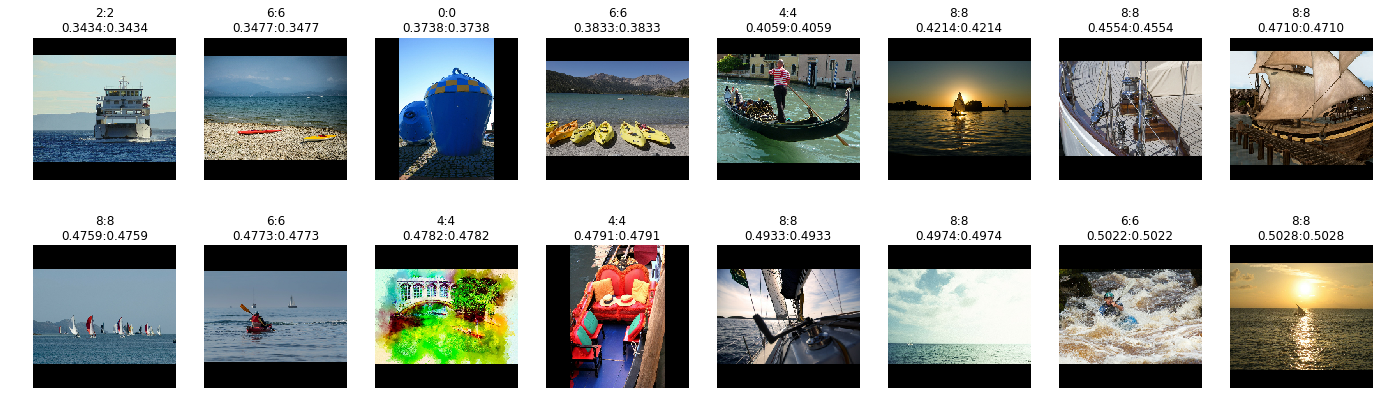

In [42]:
learner.show_predictions(correct=True, ascending=True)

In [0]:
learner = ImageLearner(
    path=TEMP_DIR/"efficientnetb0_v1",
    data=data_container,
    base_model=efn.EfficientNetB0,
    input_shape=IMG_DIMS,
    dropout=0.5,
    l1=1e-5,
    l2=1e-4,
    load=True,
)

We train once again, but using already pretrained model/weights from previous steps

In [48]:
train_learner(learner, epochs=(0, 0, 1))

Train for 92 steps, validate for 46 steps
Train for 92 steps, validate for 46 steps
Train for 92 steps, validate for 46 steps
92/92 [==============================] - 153s 2s/step - loss: 1.2015 - sparse_categorical_accuracy: 0.6658 - sparse_top_2_categorical_accuracy: 0.7785 - val_loss: 1.1193 - val_sparse_categorical_accuracy: 0.6957 - val_sparse_top_2_categorical_accuracy: 0.8207
--------------------------------------------------------------------------------
Name: efficientnet-b0 Train Time: 2.6 min. Eval Time: 15.09s Loss: 1.1193 Accuracy: 69.57%
--------------------------------------------------------------------------------


In [0]:
LearnerParams = namedtuple("LearnerParams", ["path", "base"])

In [53]:

learners = []

for path, base_model in [
    LearnerParams("resnet50_v1", keras.applications.ResNet50),
    LearnerParams("mobilenetv2_v1", keras.applications.MobileNetV2),
    LearnerParams("xception_v1", keras.applications.Xception),
    LearnerParams("efficientnetb4_v1", efn.EfficientNetB4),
]:
    learner = ImageLearner(
        path=path,
        data=data_container,
        base_model=base_model,
        input_shape=IMG_DIMS,
        dropout=0.5,
        l1=3e-5,
        l2=3e-4,
        override=True,
        load=True,
    )
    train_learner(learner)
    learners.append(learner.history.history.copy())
    del learner

Train for 92 steps, validate for 46 steps
Epoch 1/3
92/92 [==============================] - 114s 1s/step - loss: 1.2712 - sparse_categorical_accuracy: 0.6535 - sparse_top_2_categorical_accuracy: 0.8084 - val_loss: 3.4384 - val_sparse_categorical_accuracy: 0.0326 - val_sparse_top_2_categorical_accuracy: 0.0679
Epoch 2/3
92/92 [==============================] - 111s 1s/step - loss: 1.0688 - sparse_categorical_accuracy: 0.7052 - sparse_top_2_categorical_accuracy: 0.8383 - val_loss: 3.3503 - val_sparse_categorical_accuracy: 0.0299 - val_sparse_top_2_categorical_accuracy: 0.0679
Epoch 3/3
92/92 [==============================] - 110s 1s/step - loss: 1.0599 - sparse_categorical_accuracy: 0.6970 - sparse_top_2_categorical_accuracy: 0.8342 - val_loss: 3.2815 - val_sparse_categorical_accuracy: 0.0489 - val_sparse_top_2_categorical_accuracy: 0.0734
Train for 92 steps, validate for 46 steps
Epoch 1/5
92/92 [==============================] - 311s 3s/step - loss: 1.1822 - sparse_categorical_accura

W0905 14:10:47.947731 140626248046464 callbacks.py:1823] Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,sparse_categorical_accuracy,sparse_top_2_categorical_accuracy,lr
W0905 14:10:47.948761 140626248046464 callbacks.py:989] Can save best model only with val_loss available, skipping.
W0905 14:10:47.950013 140626248046464 callbacks.py:1249] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,sparse_categorical_accuracy,sparse_top_2_categorical_accuracy,lr


KeyboardInterrupt: ignored

In [0]:
def train_learner(learner, epochs=(5, 15, 5), lrs=(1e-4, 1e-4, 1e-5)):
    start_time = time.time()
    learner.freeze()
    learner.compile(keras.optimizers.Adam, lrs[0])
    learner.train(epochs[0])
    learner.unfreeze()
    learner.compile(keras.optimizers.Adam, lrs[1])
    learner.train(epochs[1])
    learner.compile(keras.optimizers.SGD, lrs[2])
    learner.train(epochs[2])
    end_time = time.time()
    
    eval_start_time = time.time()
    loss, accuracy, top_2_accuracy = learner.evaluate_dataset(verbose=0)
    eval_end_time = time.time()
    
    print("-".center(80, "-"))
    print(
        "Name: {} Train Time: {:.1f} min. Eval Time: {:.2f}s Loss: {:.4f} Accuracy: {:.2%}".format(
            learner.base_model.name,
            (end_time - start_time) / 60,
            (eval_end_time - eval_start_time),
            loss,
            accuracy,
        )
    )
    print("-".center(80, "-"))

In [55]:
learner = ImageLearner(
    path=TEMP_DIR/"mobilenetv2_v1",
    data=data_container,
    base_model=keras.applications.MobileNetV2,
    input_shape=IMG_DIMS,
    dropout=0.5,
    l1=3e-5,
    l2=3e-4,
    load=False,
)

9412608/9406464 [==============================] - 1s 0us/step


In [56]:
train_learner(learner, epochs=(2,3,2))

Train for 92 steps, validate for 46 steps
Epoch 1/2
92/92 [==============================] - 59s 645ms/step - loss: 6.6066 - sparse_categorical_accuracy: 0.1957 - sparse_top_2_categorical_accuracy: 0.3424 - val_loss: 3.3659 - val_sparse_categorical_accuracy: 0.2418 - val_sparse_top_2_categorical_accuracy: 0.4293
Epoch 2/2
92/92 [==============================] - 61s 663ms/step - loss: 5.9743 - sparse_categorical_accuracy: 0.2079 - sparse_top_2_categorical_accuracy: 0.3954 - val_loss: 2.9411 - val_sparse_categorical_accuracy: 0.3071 - val_sparse_top_2_categorical_accuracy: 0.5082
Train for 92 steps, validate for 46 steps
Epoch 1/3
92/92 [==============================] - 132s 1s/step - loss: 2.2170 - sparse_categorical_accuracy: 0.3641 - sparse_top_2_categorical_accuracy: 0.5476 - val_loss: 1.3075 - val_sparse_categorical_accuracy: 0.6250 - val_sparse_top_2_categorical_accuracy: 0.7799
Epoch 2/3
92/92 [==============================] - 127s 1s/step - loss: 1.6254 - sparse_categorical_ac

KeyError: ignored

Exploring results of trained model with "mobilenetv2_v1" architecture

In [0]:
learner.show_predictions(correct=True, ascending=True)

## Summary:

Name: efficientnet-b0 Loss: 1.1 Accuracy: 69.57%

Name: resnet50_v1 Loss: 4,4 Accuracy: 15%

Name: mobilenetv2_v1 Loss: 1,1 Accuracy: 72%

